# Predictive Maintainance for Household Appliances Using IoT Data

__Problem Statement__:
Household appliances (e.g., refrigerators, washing machines) can fail unexpectedly, leading to inconvenience and repair costs. By analyzing IoT sensor data (e.g., temperature, vibration, power consumption), we can predict when an appliance is likely to fail and recommend maintenance.

__Scope__:
Focus on one type of appliance (e.g., a refrigerator) and simulate IoT data for this project. The goal is to predict the likelihood of failure within the next 7 days.

In [152]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import random
from datetime import datetime, timedelta

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay

print("Done!")

Done!


## Import and Explore Data

In [118]:
# Load the data
df = pd.read_csv('data/energydata_complete.csv')
print("Data type : ", type(df))
print("Shape", df.shape)
df.head()

Data type :  <class 'pandas.core.frame.DataFrame'>
Shape (19735, 29)


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


#### Variable Information
| Variable Name  | Description                                                 |
|----------------|-------------------------------------------------------------|
| date           | Time year-month-day hour:minute:second                     |
| Appliances     | Energy use in Wh                                           |
| lights         | Energy use of light fixtures in the house in Wh            |
| T1             | Temperature in kitchen area, in Celsius                    |
| RH_1           | Humidity in kitchen area, in %                             |
| T2             | Temperature in living room area, in Celsius                |
| RH_2           | Humidity in living room area, in %                         |
| T3             | Temperature in laundry room area                            |
| RH_3           | Humidity in laundry room area, in %                        |
| T4             | Temperature in office room, in Celsius                     |
| RH_4           | Humidity in office room, in %                              |
| T5             | Temperature in bathroom, in Celsius                        |
| RH_5           | Humidity in bathroom, in %                                 |
| T6             | Temperature outside the building (north side), in Celsius  |
| RH_6           | Humidity outside the building (north side), in %           |
| T7             | Temperature in ironing room, in Celsius                    |
| RH_7           | Humidity in ironing room, in %                             |
| T8             | Temperature in teenager room 2, in Celsius                 |
| RH_8           | Humidity in teenager room 2, in %                         |
| T9             | Temperature in parents room, in Celsius                    |
| RH_9           | Humidity in parents room, in %                             |
| To             | Temperature outside (from Chievres weather station), in Celsius |
| Pressure       | Pressure (from Chievres weather station), in mm Hg         |
| RH_out         | Humidity outside (from Chievres weather station), in %     |
| Wind speed     | Wind speed (from Chievres weather station), in m/s        |
| Visibility     | Visibility (from Chievres weather station), in km         |
| Tdewpoint      | Dew point temperature (from Chievres weather station), in °C |
| rv1            | Random variable 1, nondimensional                          |
| rv2            | Random variable 2, nondimensional                          |


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [120]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [121]:
# Convert the date column to datetime
df["date"] = pd.to_datetime(df["date"])

# Create timebase features
df["hour"] = df["date"].dt.hour
df["day_of_week"] = df["date"].dt.dayofweek

In [88]:
df.hour.unique()

array([17, 18, 19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16], dtype=int32)

In [89]:
df.day_of_week.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

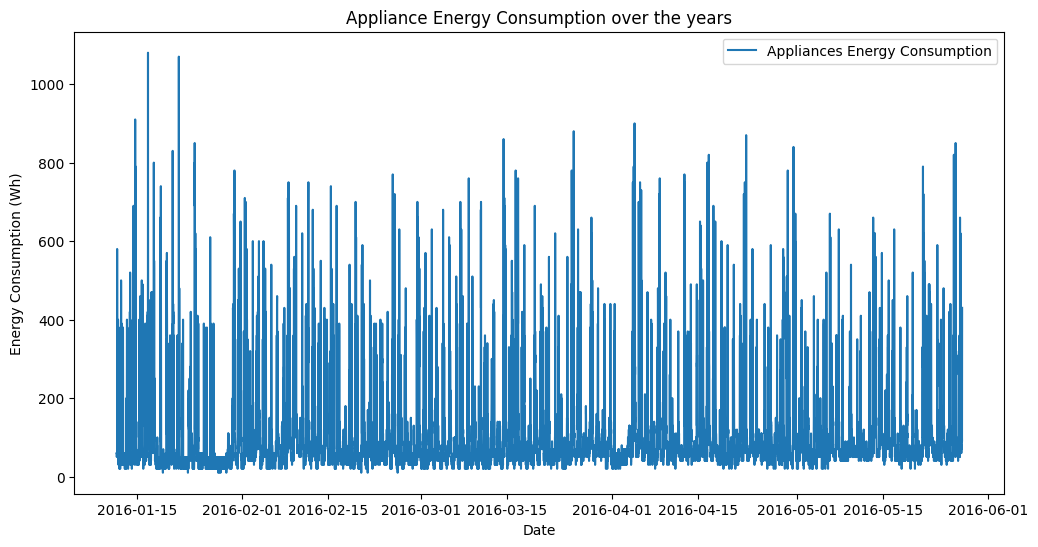

In [122]:
# Visualize the Energy consumption over the years
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['Appliances'], label='Appliances Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (Wh)')
plt.title('Appliance Energy Consumption over the years')
plt.legend()
plt.show()

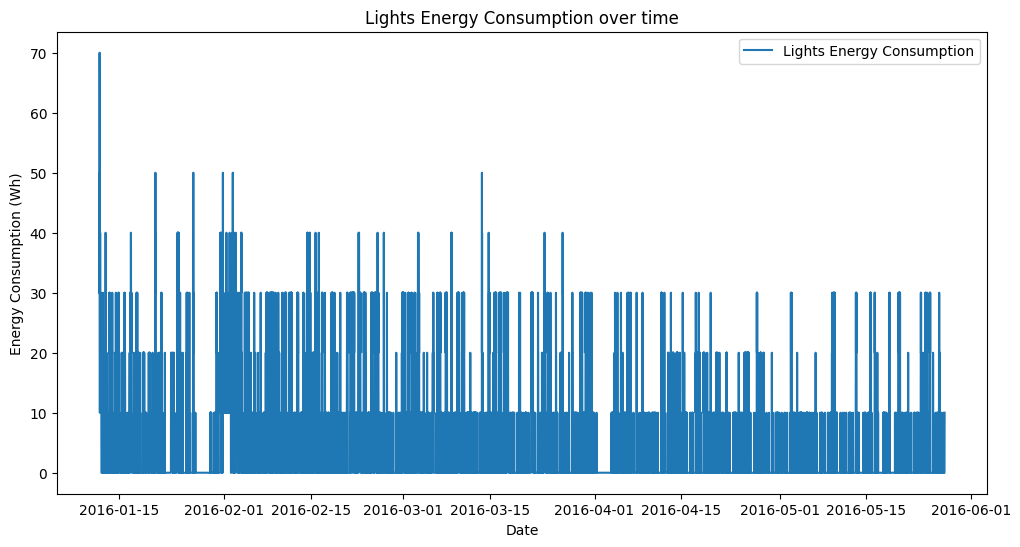

In [123]:
# Visualize the Energy consumption over time
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['lights'], label='Lights Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (Wh)')
plt.title('Lights Energy Consumption over time')
plt.legend()
plt.show()

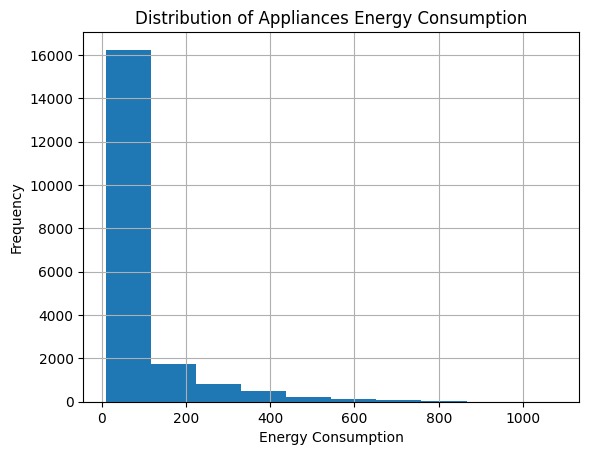

In [124]:
# Visulalize the distribution of appliace
df["Appliances"].hist(bins=10)
plt.xlabel("Energy Consumption")
plt.ylabel("Frequency")
plt.title("Distribution of Appliances Energy Consumption");

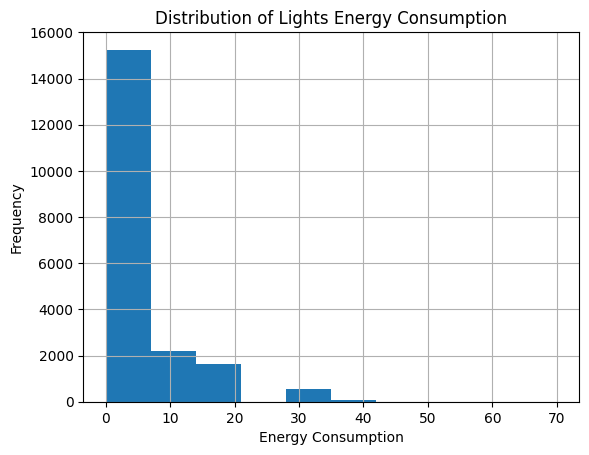

In [125]:
# Visulalize the distribution of lights
df["lights"].hist(bins=10)
plt.xlabel("Energy Consumption")
plt.ylabel("Frequency")
plt.title("Distribution of Lights Energy Consumption");

In [128]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'hour', 'day_of_week'],
      dtype='object')

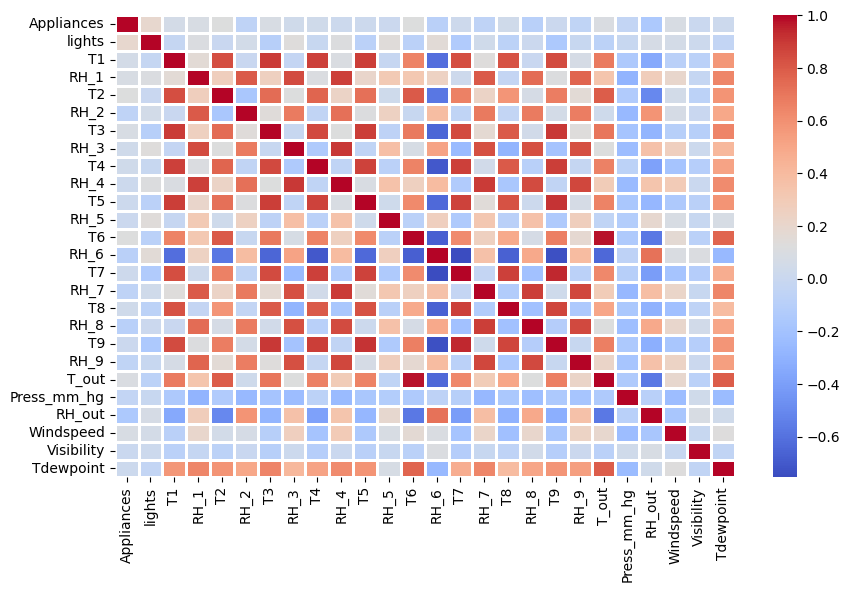

In [129]:
corr = df.drop(columns=["date", "rv1", "rv2", "hour", "day_of_week"]).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap='coolwarm', fmt=".2f", linewidths=2);

### Split
For predictive maintenance, we need to define a target variable that indicates potential failures or abnormal behavior.

In [130]:
threshold = df["Appliances"].quantile(0.95)  # Top 5% of energy consumption
df["failures"] = [1 if x > threshold else 0 for x in df["Appliances"]]

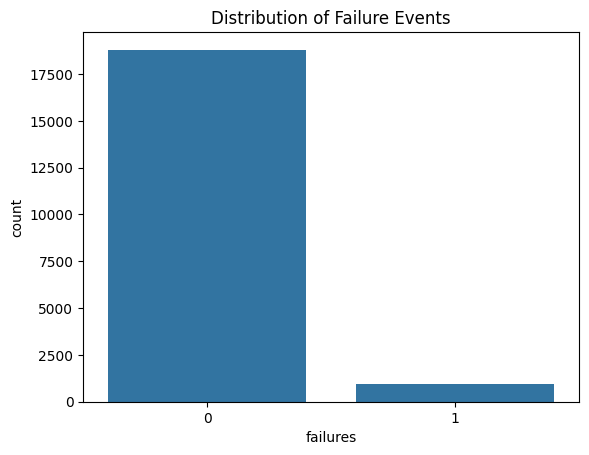

In [132]:
# Visualize the distribution
sns.countplot(x="failures", data=df)
plt.title("Distribution of Failure Events")
plt.show()

In [133]:
df["failures"].value_counts()

failures
0    18800
1      935
Name: count, dtype: int64

In [135]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'hour', 'day_of_week',
       'failures'],
      dtype='object')

In [136]:
# define the features and target variable
X = df.drop(columns=["date", "Appliances", "failures"])
y = df["failures"]

In [137]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(15788, 29) (3947, 29)


In [138]:
smote = SMOTE(random_state=42)

In [139]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"X_train_smote shape: {X_train_smote.shape}, y_train_smote shape: {y_train_smote.shape}")

X_train_smote shape: (30060, 29), y_train_smote shape: (30060,)


In [140]:
# Train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [141]:
# Make prediction
y_pred = rf_model.predict(X_test)

In [142]:
# Evaluate the model
acc_train = rf_model.score(X_train_smote, y_train_smote)
acc_test = rf_model.score(X_test, y_test)

print(f"Train Accuracy: {acc_train:.2f}")
print(f"Test Accuracy: {acc_test:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.96


In [143]:
# Get the number of values in the test data
y_test.value_counts()

failures
0    3770
1     177
Name: count, dtype: int64

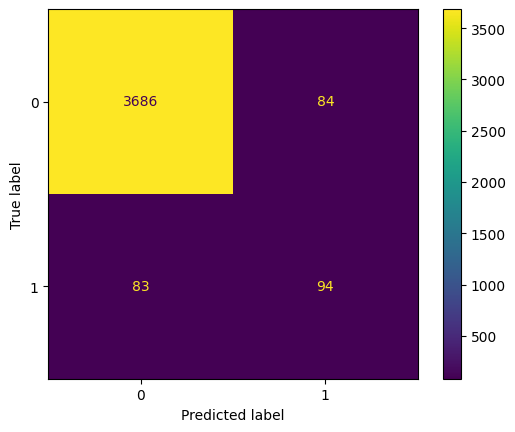

In [144]:
# Plot confusion matrix that shows how the model performs on test data
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)

In [145]:
# Evaluate the model

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[3686   84]
 [  83   94]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3770
           1       0.53      0.53      0.53       177

    accuracy                           0.96      3947
   macro avg       0.75      0.75      0.75      3947
weighted avg       0.96      0.96      0.96      3947



## Communication

In [146]:
# decalre confusion matrix in a variable
cm = confusion_matrix(y_test, y_pred)

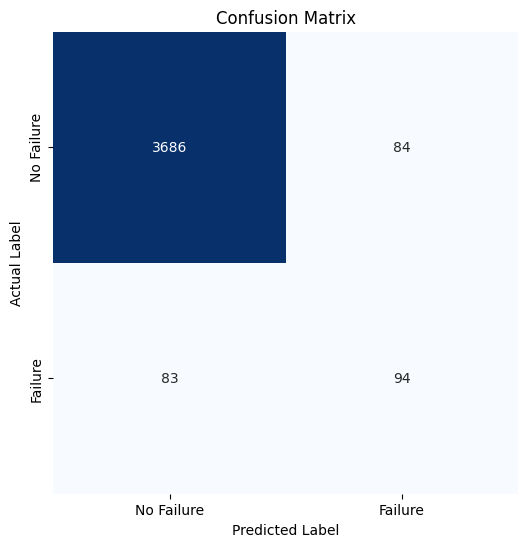

In [147]:
# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            
            xticklabels=['No Failure', 'Failure'],
            yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

<Figure size 600x600 with 0 Axes>

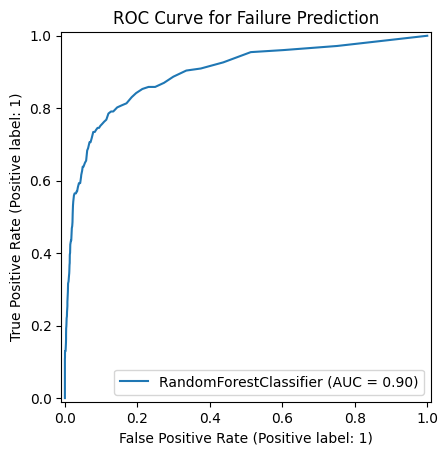

In [148]:
# Plot ROC curve
plt.figure(figsize=(6, 6))
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve for Failure Prediction")
plt.show()

C:\Users\Rodri\AppData\Local\Temp\ipykernel_6580\3845358344.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(10), palette="viridis")


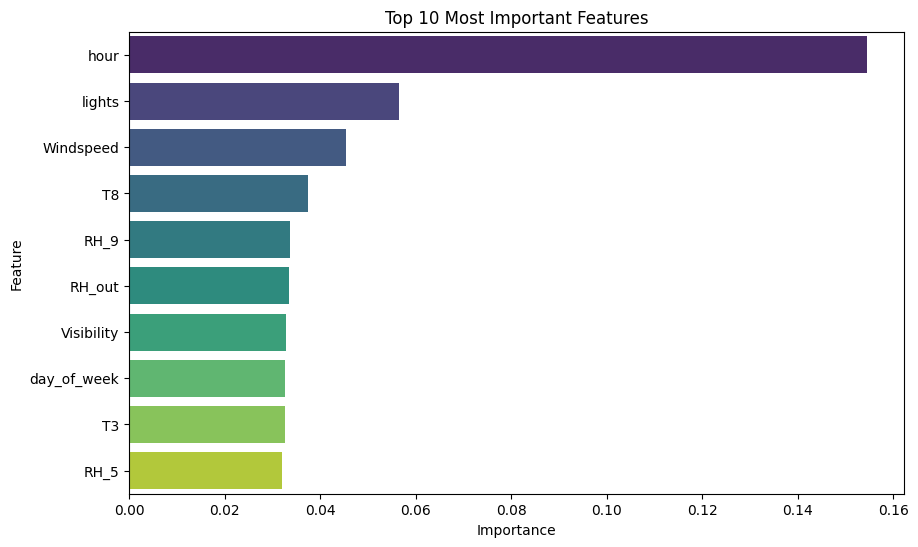

In [149]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(10), palette="viridis")
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Show the distribution of predicted probabilities for failures and non-failures. This helps explain how confident the model is in its predictions.

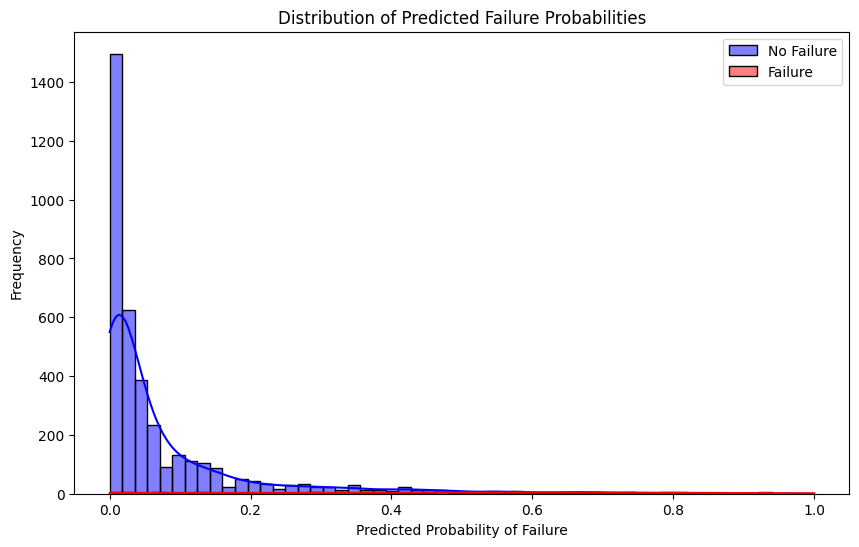

In [ ]:
# Get predicted probabilities for Class 1 (failures)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba[y_test == 0], bins=50, label="No Failure", color="blue", kde=True, alpha=0.5)
sns.histplot(y_pred_proba[y_test == 1], bins=50, label="Failure", color="red", kde=True, alpha=0.5)
plt.xlabel("Predicted Probability of Failure")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Failure Probabilities")
plt.legend()
plt.show()

In [159]:
# Save the model and the test data
results_df = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred,
})
results_df.to_csv("results.csv", index=False)

In [160]:
# Save X test dara
X_test.to_csv("x_test.csv", index=False)

In [155]:
# Save the trained model to a pickle file
with open("rf_model.pkl", "wb") as file:
    pickle.dump(rf_model, file)

In [156]:
# Save feature importances to a CSV file
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
})
importance_df.to_csv("feature_importances.csv", index=False)

In [163]:
X_test.columns

Index(['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5',
       'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
       'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1',
       'rv2', 'hour', 'day_of_week'],
      dtype='object')

In [169]:
df["Windspeed"].unique()

array([ 7.        ,  6.66666667,  6.33333333,  6.        ,  5.66666667,
        5.33333333,  5.        ,  5.16666667,  5.5       ,  5.83333333,
        6.16666667,  6.5       ,  6.83333333,  4.83333333,  4.66666667,
        4.5       ,  4.33333333,  4.16666667,  4.        ,  7.16666667,
        7.33333333,  7.5       ,  7.66666667,  7.83333333,  8.        ,
        3.83333333,  3.66666667,  3.5       ,  3.33333333,  3.16666667,
        3.        ,  8.33333333,  9.        ,  8.83333333,  8.66666667,
        8.5       ,  8.16666667,  9.33333333,  9.66666667, 10.        ,
        9.16666667,  9.5       ,  9.83333333, 10.16666667, 10.33333333,
       10.5       , 10.66666667, 10.83333333, 11.        ,  2.5       ,
        2.        ,  2.16666667,  2.33333333,  2.66666667,  2.83333333,
        1.66666667,  1.33333333,  1.        ,  1.83333333,  1.5       ,
        1.16666667,  0.83333333,  0.66666667,  0.5       ,  0.33333333,
        0.16666667,  0.        ,  1.94444444,  1.88888889,  1.77